# Importing The Requirements

In [1]:
# Imports
import os
import tempfile
import time

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pooch

In [2]:
# functions

%matplotlib inline

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/ENSO' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

In [3]:
# Ocean surface temprature 
filename_SST='sst.mnmean.nc'
url_SST = 'https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc'

do_sst = xr.open_dataset(pooch_load(url_SST,filename_SST), drop_variables=['time_bnds'])

# Precipitation rate (notice the units in the plot below)
filename_prec_rate='precip.mon.mean.nc'
url_prec_rate='https://downloads.psl.noaa.gov/Datasets/cmap/enh/precip.mon.mean.nc'
do_pr = xr.open_dataset(pooch_load(url_prec_rate,filename_prec_rate))

# Air Temperature Anomalies
filename_tas='air.2x2.1200.mon.anom.comb.nc'
url_tas='https://downloads.psl.noaa.gov/Datasets/gistemp/combined/1200km/air.2x2.1200.mon.anom.comb.nc'
do_tas = xr.open_dataset(pooch_load(url_tas,filename_tas))

# Regression Analysis

In [4]:
def Nino_anomaly(ds):
    tos_nino34 = ds.where(
    (ds.lat < 5) & (ds.lat > -5) & (ds.lon > 190) & (ds.lon < 240),drop=True)  # use dataset where function. use boolean commands
    tos_nino34_mon = tos_nino34.sst.groupby("time.month")
    tos_nino34_clim = tos_nino34_mon.mean(dim="time")
    tos_anomaly=tos_nino34_mon - tos_nino34_clim 
    tos_nino34_anom_mean = tos_anomaly.mean(dim=["lat", "lon"])
    nino_index=tos_nino34_anom_mean.rolling(time=5, center=True).mean()
    return nino_index

In [5]:
def global_regression(x, y, var):
    # Initialize an empty xarray dataset to store the results
    result_ds = xr.Dataset(coords={'lat': y['lat'], 'lon': y['lon']})
    result_ds['slope'] = xr.DataArray(np.nan, coords=result_ds.coords, dims=result_ds.dims)
    result_ds['intercept'] = xr.DataArray(np.nan, coords=result_ds.coords, dims=result_ds.dims)
    result_ds['r_value'] = xr.DataArray(np.nan, coords=result_ds.coords, dims=result_ds.dims)
    result_ds['p_value'] = xr.DataArray(np.nan, coords=result_ds.coords, dims=result_ds.dims)
    result_ds['std_err'] = xr.DataArray(np.nan, coords=result_ds.coords, dims=result_ds.dims)

    # Iterate over each lat-lon location
    for lat in y['lat']:
        for lon in y['lon']:
            # Extract the data for the current lat-lon location
            y_ = y.sel(lat=lat, lon=lon)[var].values
            idx = np.isnan(x) | np.isnan(y_)
            x_ = np.asarray(x)[~idx]
            y_ = np.asarray(y_)[~idx]
            # Perform linear regression
            try:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x_, y_)

                # Store the correlation (r) and p-value in the result dataset
                result_ds['slope'].loc[{'lat': lat, 'lon': lon}] = slope
                result_ds['intercept'].loc[{'lat': lat, 'lon': lon}] = intercept
                
                if (p_value>0.05):
                    result_ds['r_value'].loc[{'lat': lat, 'lon': lon}] = np.nan
                else:
                    result_ds['r_value'].loc[{'lat': lat, 'lon': lon}] = r_value
                result_ds['p_value'].loc[{'lat': lat, 'lon': lon}] = p_value
                result_ds['std_err'].loc[{'lat': lat, 'lon': lon}] = std_err
            except:
                # slope, intercept, r_value, p_value, std_err = stats.linregress(x_, y_)÷

                # Store the correlation (r) and p-value in the result dataset
                result_ds['slope'].loc[{'lat': lat, 'lon': lon}] = np.nan
                result_ds['intercept'].loc[{'lat': lat, 'lon': lon}] = np.nan
                result_ds['r_value'].loc[{'lat': lat, 'lon': lon}] = np.nan
                result_ds['p_value'].loc[{'lat': lat, 'lon': lon}] = np.nan
                result_ds['std_err'].loc[{'lat': lat, 'lon': lon}] = np.nan

    # The result_ds will contain the correlation (r) and p-values for each lat-lon location
    return result_ds


## Percipitation

In [6]:
ONI = Nino_anomaly(do_sst)
pr_monthly_anomaly = do_pr.groupby('time.month') - do_pr.groupby('time.month').mean()
ONI = ONI.sel(time=slice(pr_monthly_anomaly.time.min(), pr_monthly_anomaly.time.max()))
precip_ONI_LR = global_regression(ONI, pr_monthly_anomaly, 'precip')

## SST

In [7]:
ONI = Nino_anomaly(do_sst)
sst_monthly_anomaly = do_sst.groupby('time.month') - do_sst.groupby('time.month').mean()
sst_ONI_LR = global_regression(ONI, sst_monthly_anomaly, 'sst')

## Air Temperature

In [8]:
ONI = Nino_anomaly(do_sst)
air_monthly_anomaly = do_tas.groupby('time.month') - do_tas.groupby('time.month').mean()
ONI = ONI.sel(time=slice(air_monthly_anomaly.time.min(), air_monthly_anomaly.time.max()))
air_ONI_LR = global_regression(ONI, air_monthly_anomaly, 'air')

# Figures

Text(0.5, 1.0, 'c. Air Temperature and ONI Correlation')

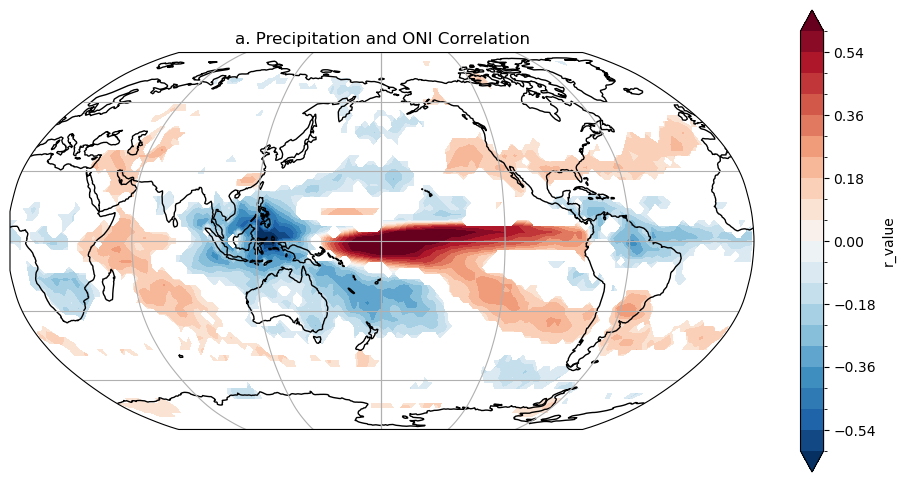

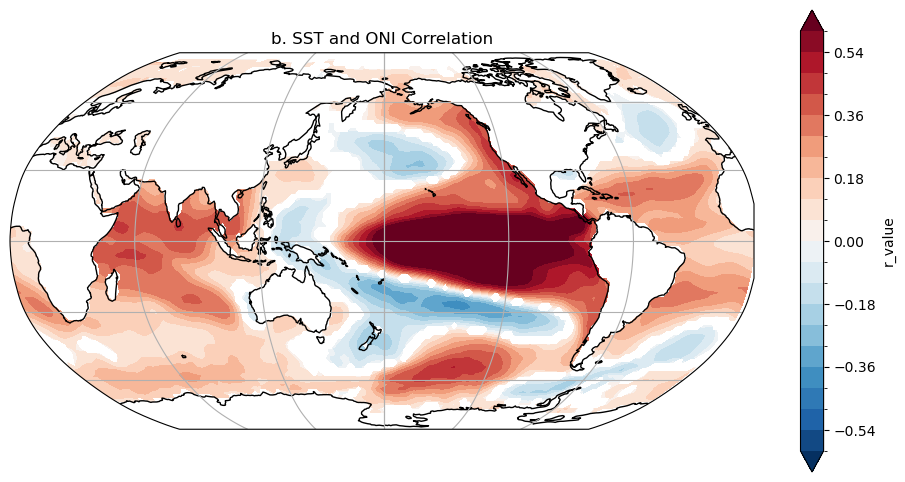

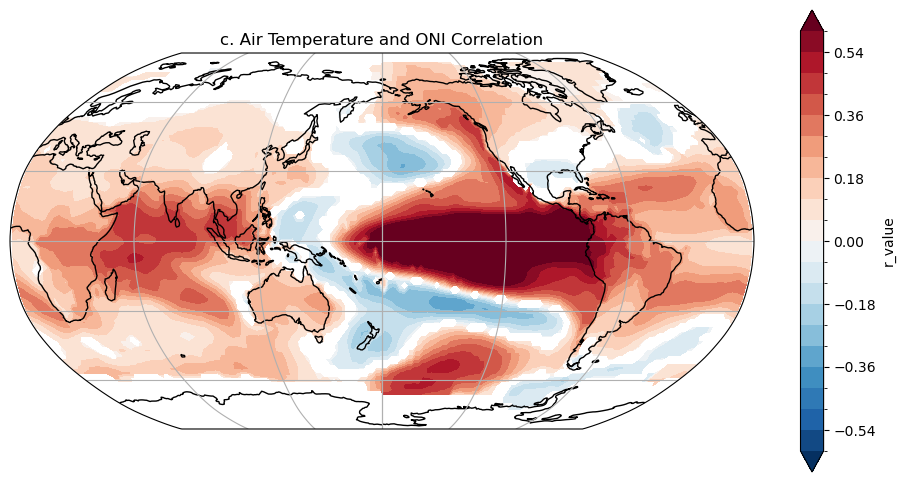

In [9]:
fig, ax = plt.subplots(
    ncols=1, nrows=1, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson(central_longitude=180)}
)

contour_levels = np.linspace(-0.6, 0.6, 21)  # Adjust the number of levels as needed
contour = precip_ONI_LR.r_value.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=contour_levels, cmap='RdBu_r', extend='both')

# Add coastlines for reference
ax.coastlines()

# Add gridlines
ax.gridlines()

# Set plot title
plt.title('a. Precipitation and ONI Correlation')

fig, ax = plt.subplots(
    ncols=1, nrows=1, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson(central_longitude=180)}
)

contour_levels = np.linspace(-0.6, 0.6, 21)  # Adjust the number of levels as needed
contour = sst_ONI_LR.r_value.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=contour_levels, cmap='RdBu_r', extend='both')

# Add coastlines for reference
ax.coastlines()

# Add gridlines
ax.gridlines()

# Set plot title
plt.title('b. SST and ONI Correlation')

fig, ax = plt.subplots(
    ncols=1, nrows=1, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson(central_longitude=180)}
)

contour_levels = np.linspace(-0.6, 0.6, 21)  # Adjust the number of levels as needed
contour = air_ONI_LR.r_value.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=contour_levels, cmap='RdBu_r', extend='both')

# Add coastlines for reference
ax.coastlines()

# Add gridlines
ax.gridlines()

# Set plot title
plt.title('c. Air Temperature and ONI Correlation')

# Supplementary Figures

In [10]:

sst_LR_interp = sst_ONI_LR.interp(lat=air_ONI_LR['lat'], lon=air_ONI_LR['lon'])


In [11]:
diff = ((air_ONI_LR['r_value'] * sst_LR_interp['r_value'])<0)*(1)

Text(0.5, 1.0, 'Is (SST Correlation * Air Temperature Correlation) negative?')

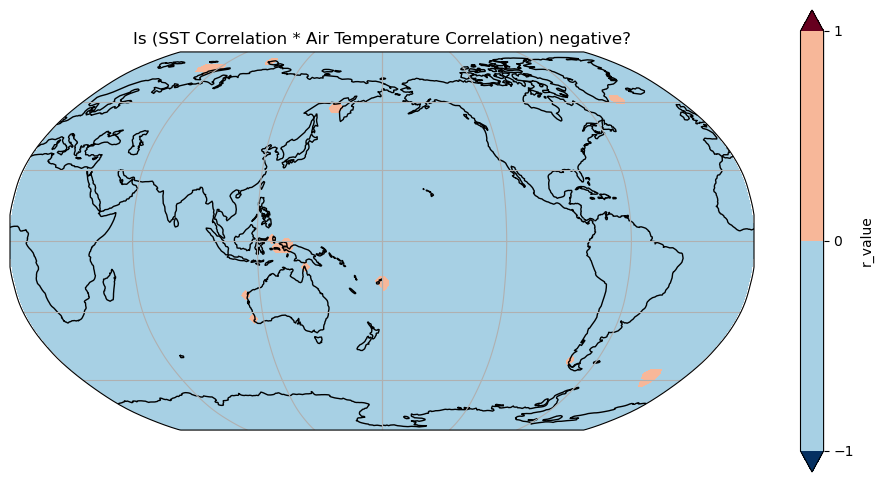

In [12]:
fig, ax = plt.subplots(
    ncols=1, nrows=1, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson(central_longitude=180)}
)

contour_levels = np.linspace(-1, 1, 3)  # Adjust the number of levels as needed
contour = diff.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=contour_levels, cmap='RdBu_r', extend='both')

# Add coastlines for reference
ax.coastlines()

# Add gridlines
ax.gridlines()

# Set plot title
plt.title('Is (SST Correlation * Air Temperature Correlation) negative?')

Text(0.5, 1.0, '|Air Temperature Correlation| - |SST correlation|')

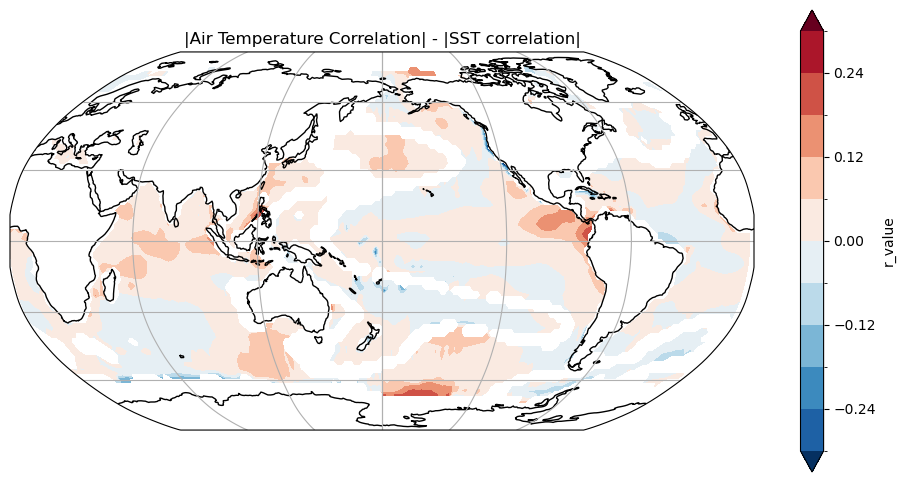

In [13]:
diff = ((air_ONI_LR['r_value'] - sst_LR_interp['r_value'])*((air_ONI_LR['r_value'])>=0) +(sst_LR_interp['r_value'] - air_ONI_LR['r_value'])*((air_ONI_LR['r_value'])<0))*((air_ONI_LR['r_value'] * sst_LR_interp['r_value'])>=0)
fig, ax = plt.subplots(
    ncols=1, nrows=1, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson(central_longitude=180)}
)

contour_levels = np.linspace(-0.3, 0.3, 11)  # Adjust the number of levels as needed
contour = diff.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=contour_levels, cmap='RdBu_r', extend='both')

# Add coastlines for reference
ax.coastlines()

# Add gridlines
ax.gridlines()

# Set plot title
plt.title('|Air Temperature Correlation| - |SST correlation|')